In [ ]:
from qiskit.circuit import classical_function, Int1
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit

NUMBER_OF_BITS = 6
INDEX_OF_ALL_BITS = range(NUMBER_OF_BITS)
NUMBER_OF_ROUNDS = 3

@classical_function
def bitoracle(x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1) -> Int1:
    return (not x5 and not x4 and x3 and not x2 and x1) or (not x5 and not x4 and x3 and x2 and not x1) \
        or (not x5 and x4 and x3 and not x2 and not x1) or (x5 and not x4 and not x3 and not x2 and x1) \
        or (x5 and not x4 and x3 and not x2 and not x1) or (x5 and x4 and not x3 and not x2 and not x1)

def phaseOracle():
    phaseoracle = QuantumCircuit(NUMBER_OF_BITS)
    phaseoracle.x(5)
    phaseoracle.h(5)
    
    bitcircuit = bitoracle.synth()
    phaseoracle.compose(bitcircuit, inplace=True)
    
    phaseoracle.h(5)
    phaseoracle.x(5)
    oracle = phaseoracle.to_gate()
    oracle.name = "Oracle"
    
    return oracle

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser"
    return U_s

# Construct the circuit    
grover_circuit = QuantumCircuit(NUMBER_OF_BITS, NUMBER_OF_BITS-1)

for i in INDEX_OF_ALL_BITS:
    grover_circuit.h(i)

theOracle = phaseOracle()
theDiffuser = diffuser(NUMBER_OF_BITS)
for _ in range(NUMBER_OF_ROUNDS):
    grover_circuit.append(theOracle, INDEX_OF_ALL_BITS)
    grover_circuit.append(theDiffuser, INDEX_OF_ALL_BITS)

grover_circuit.measure([0,1,2,3,4], [0,1,2,3,4])
grover_circuit.draw()

┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐┌─────────┐»
q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├┤0        ├»
     ├───┤│         ││           ││         ││           ││         │»
q_1: ┤ H ├┤1        ├┤1          ├┤1        ├┤1          ├┤1        ├»
     ├───┤│         ││           ││         ││           ││         │»
q_2: ┤ H ├┤2        ├┤2          ├┤2        ├┤2          ├┤2        ├»
     ├───┤│  Oracle ││  Diffuser ││  Oracle ││  Diffuser ││  Oracle │»
q_3: ┤ H ├┤3        ├┤3          ├┤3        ├┤3          ├┤3        ├»
     ├───┤│         ││           ││         ││           ││         │»
q_4: ┤ H ├┤4        ├┤4          ├┤4        ├┤4          ├┤4        ├»
     ├───┤│         ││           ││         ││           ││         │»
q_5: ┤ H ├┤5        ├┤5          ├┤5        ├┤5          ├┤5        ├»
     └───┘└─────────┘└───────────┘└─────────┘└───────────┘└─────────┘»
c: 5/════════════════════════════════════════════════════════════════»
                                                                     »
«     ┌───────────┐┌─┐            
«q_0: ┤0          ├┤M├────────────
«     │           │└╥┘┌─┐         
«q_1: ┤1          ├─╫─┤M├─────────
«     │           │ ║ └╥┘┌─┐      
«q_2: ┤2          ├─╫──╫─┤M├──────
«     │  Diffuser │ ║  ║ └╥┘┌─┐   
«q_3: ┤3          ├─╫──╫──╫─┤M├───
«     │           │ ║  ║  ║ └╥┘┌─┐
«q_4: ┤4          ├─╫──╫──╫──╫─┤M├
«     │           │ ║  ║  ║  ║ └╥┘
«q_5: ┤5          ├─╫──╫──╫──╫──╫─
«     └───────────┘ ║  ║  ║  ║  ║ 
«c: 5/══════════════╩══╩══╩══╩══╩═
«                   0  1  2  3  4

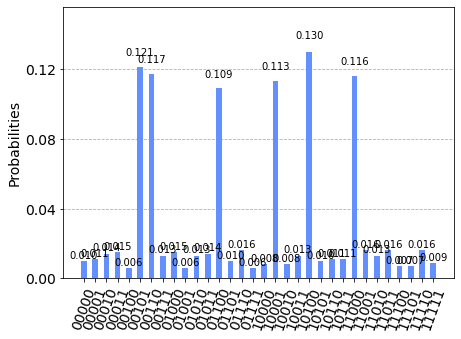

In [18]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_circuit, backend=simulator, shots=1000).result().get_counts(grover_circuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)